# Notebook for looking at output of MobileTrans iphone transfer Simessage data 

In [47]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import colorcet as cc


In [2]:
df = pd.read_csv('../data/Connor_phone_SMS_20230923121617.csv')

/var/folders/29/pk1kpcg97nj2vqxkp3_5zbqc0000gn/T/ipykernel_16671/2985932616.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/Connor_phone_SMS_20230923121617.csv')


In [3]:
df['time_datetime'] = pd.to_datetime(df['Time'])
df = df.sort_values(by='time_datetime')

/var/folders/29/pk1kpcg97nj2vqxkp3_5zbqc0000gn/T/ipykernel_16671/1646663826.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time_datetime'] = pd.to_datetime(df['Time'])


In [4]:
df['year_month'] = df['time_datetime'].apply(lambda x: x.strftime('%Y-%m'))
df['Name'] = df['Name'].apply(lambda x: x.strip())
df['Number'] = df['Number'].apply(lambda x: x.strip())
df['Content'] = df['Content'].str.lower()

In [5]:
date_range = pd.date_range(min(df['time_datetime']), max(df['time_datetime']), freq='MS')

In [6]:
df['from_number'] = df.apply(lambda row: '17169492354' if row['Name'] == 'Me' else row['Number'], axis=1)

In [35]:
top_n = 10
messages_count_df = df.groupby(['from_number']).from_number.count().reset_index(name='num_messages')
top_numbers = set(messages_count_df.sort_values(by='num_messages', ascending=False)['from_number'].iloc[:top_n])

In [36]:
df['top_from_number'] = df['from_number'].apply(lambda x: x.replace('+', '')[-10:] if x in top_numbers else 'Others')

In [37]:
# Create contact
num_to_name = {'7169492354' : 'Me', 'Others' : 'Others'}
for names in set(df['Name']):
    for n in names.split(';'):
        n_s = n.split('(')
        if len(n_s) > 1:
            num_to_name[n_s[1].replace('+', '').replace(')', '')[-10:]] = n_s[0].strip()

df['from_name'] = df['top_from_number'].map(num_to_name)


([<matplotlib.axis.XTick at 0x283d20440>,
 [Text(18809.74556712963, 0, '2021-07-01'),
  Text(18840.74556712963, 0, '2021-08-01'),
  Text(18871.74556712963, 0, '2021-09-01'),
  Text(18901.74556712963, 0, '2021-10-01'),
  Text(18932.74556712963, 0, '2021-11-01'),
  Text(18962.74556712963, 0, '2021-12-01'),
  Text(18993.74556712963, 0, '2022-01-01'),
  Text(19024.74556712963, 0, '2022-02-01'),
  Text(19052.74556712963, 0, '2022-03-01'),
  Text(19083.74556712963, 0, '2022-04-01'),
  Text(19113.74556712963, 0, '2022-05-01'),
  Text(19144.74556712963, 0, '2022-06-01'),
  Text(19174.74556712963, 0, '2022-07-01'),
  Text(19205.74556712963, 0, '2022-08-01'),
  Text(19236.74556712963, 0, '2022-09-01'),
  Text(19266.74556712963, 0, '2022-10-01'),
  Text(19297.74556712963, 0, '2022-11-01'),
  Text(19327.74556712963, 0, '2022-12-01'),
  Text(19358.74556712963, 0, '2023-01-01'),
  Text(19389.74556712963, 0, '2023-02-01'),
  Text(19417.74556712963, 0, '2023-03-01'),
  Text(19448.74556712963, 0, '2023

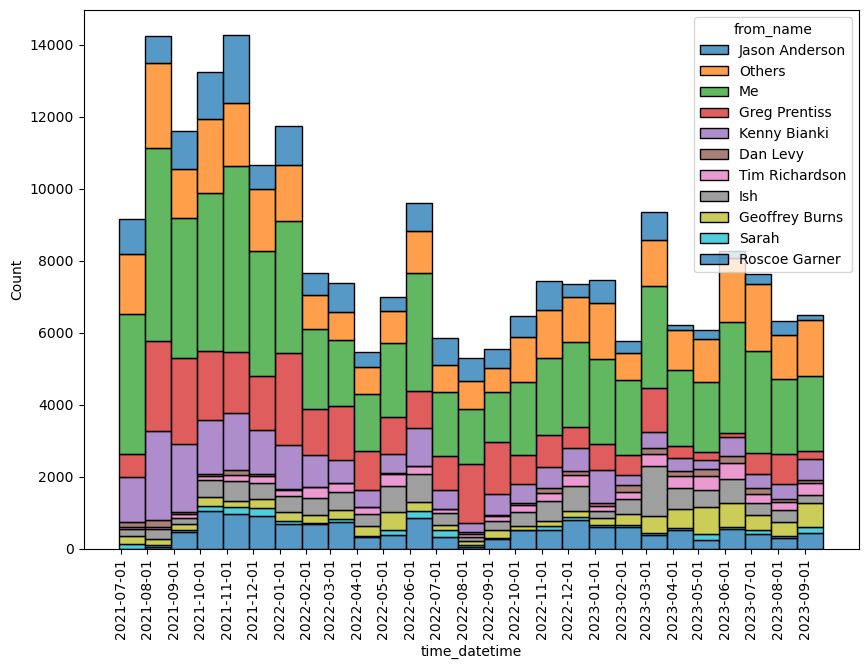

In [38]:
plt.figure(figsize=(10, 7))
sns.histplot(x='time_datetime', hue='from_name', data=df, bins=len(date_range), multiple='stack', palette='tab10')
plt.xticks(date_range, rotation=90)
# plt.legend(bbox_to_anchor=(1.0, 0.7))
# plt.legend(loc='upper right', title='species', fontsize="x-large")

# Create PCA plot using TF-IDF embeddings

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [40]:
person_text_df = df.loc[~df['Content'].isnull()].groupby(['from_name'])['Content'].agg(lambda x: ' '.join(x)).reset_index(name='combined_messages')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Dan Levy'),
  Text(1, 0, 'Geoffrey Burns'),
  Text(2, 0, 'Greg Prentiss'),
  Text(3, 0, 'Ish'),
  Text(4, 0, 'Jason Anderson'),
  Text(5, 0, 'Kenny Bianki'),
  Text(6, 0, 'Me'),
  Text(7, 0, 'Others'),
  Text(8, 0, 'Roscoe Garner'),
  Text(9, 0, 'Sarah'),
  Text(10, 0, 'Tim Richardson')])

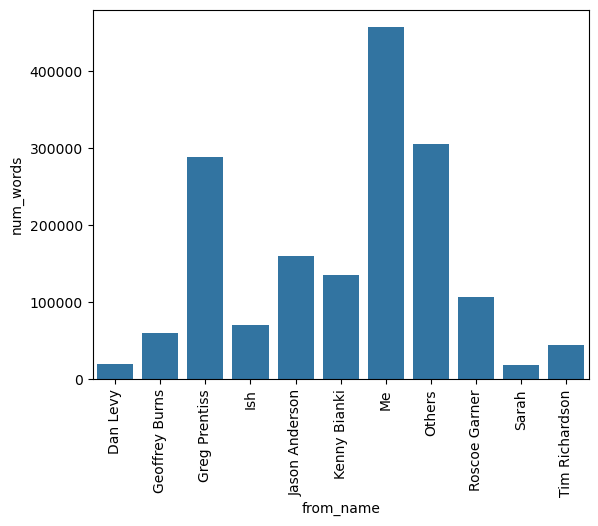

In [56]:
person_text_df['num_words'] = person_text_df['combined_messages'].apply(lambda x: len(x.split(' ')))
sns.barplot(x='from_name', y='num_words', data=person_text_df)
plt.xticks(rotation=90)

In [49]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(person_text_df['combined_messages']).toarray()

In [50]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [51]:
person_text_df['tfidf_x'] = X_pca[:,0]
person_text_df['tfidf_y'] = X_pca[:,1]

/var/folders/29/pk1kpcg97nj2vqxkp3_5zbqc0000gn/T/ipykernel_16671/3774082654.py:1: UserWarning: The palette list has more values (25) than needed (11), which may not be intended.
  sns.scatterplot(x='tfidf_x', y='tfidf_y', hue='from_name', data=person_text_df, palette=sns.color_palette(cc.glasbey, n_colors=25))


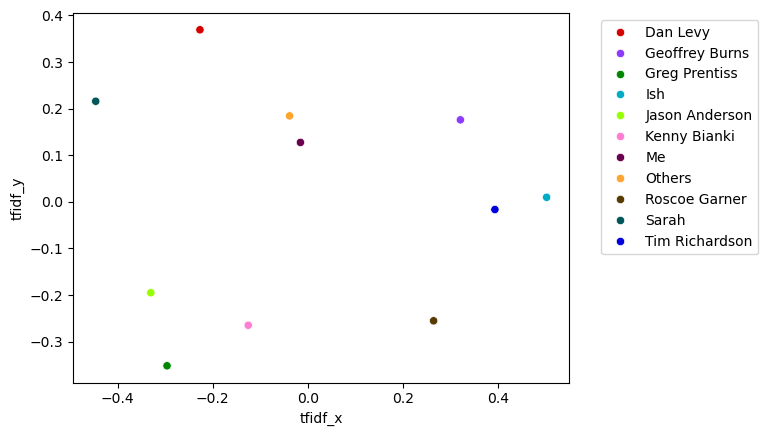

In [52]:
sns.scatterplot(x='tfidf_x', y='tfidf_y', hue='from_name', data=person_text_df, palette=sns.color_palette(cc.glasbey, n_colors=25))
plt.legend(bbox_to_anchor=(1.05, 1))